# Distgen -> Impact model of the copper injector


This example assumes the steps in the README have been completed, the model has been saved, and a deployment has been stored in the database. We will first load the model locally using the LocalModelingService and subsequently run with prefect using the RemoteModelingService.

In [1]:
import os
from slac_services.services.scheduling import MountPoint
from slac_services.utils import isotime
from slac_services import service_container
import numpy as np
import os
dir_path = os.path.abspath('')

# set up distgen inputs

In [2]:
distgen_input_filename = f"{dir_path}/files/distgen.yaml"

# we need to create mount points for each file or directory so the pod may access our filesystem resources
distgen_input_mount = MountPoint(
    name="distgen-input-mount", host_path=distgen_input_filename, mount_type="File"
)

# format inputs
vcc_array = np.load(f"{dir_path}/files/default_vcc_array.npy")

distgen_pv_values = {
    "CAMR:IN20:186:RESOLUTION" : 9,
    "CAMR:IN20:186:RESOLUTION.EGU" : "um",
    "CAMR:IN20:186:N_OF_ROW" : 480,
    "CAMR:IN20:186:N_OF_COL": 640,
    "CAMR:IN20:186:IMAGE": vcc_array.tolist(), # neet to convert to json serializable input for passed data
    "BPMS:IN20:221:TMIT": 1.51614e+09
}

distgen_configuration = {}
distgen_settings = {
    'n_particle': 10000,
    "t_dist:length:value":  4 * 1.65   #  Inferred pulse stacker FWHM: 4 ps, converted to tukey length
}

distgen_pvname_to_input_map = {
    "CAMR:IN20:186:RESOLUTION" : "vcc_resolution",
    "CAMR:IN20:186:RESOLUTION.EGU" : "vcc_resolution_units",
    "CAMR:IN20:186:N_OF_ROW" : "vcc_size_y",
    "CAMR:IN20:186:N_OF_COL": "vcc_size_x",
    "CAMR:IN20:186:IMAGE": "vcc_array",
    "BPMS:IN20:221:TMIT":"total_charge"
}

# Set up impact inputs

In [3]:
workdir = f"{dir_path}/files/output"
# will want to create a directory so use DirectoryOrCreate mount type
workdir_mount = MountPoint(
    name="workdir-mount", host_path=workdir, mount_type="DirectoryOrCreate"
)


# in this case, will be using conda installation of impact
command="ImpactTexe"
command_mpi=""
use_mpi=False
mpi_run="mpirun -n {nproc} --use-hwthread-cpus {command_mpi}"

impact_configuration = {
    "command": command,
    "command_mpi": command_mpi,
    "use_mpi": use_mpi,
    "workdir": workdir,
    "mpi_run": mpi_run
}

impact_settings = {
    "header:Nx": 32,
    "header:Ny": 32,
    "header:Nz": 32,
    "stop": 16.5,
  #  "stop": 8,
    "numprocs": 1,
    "timeout": 1000,
    "total_charge": 0, # for debugging
}

impact_archive_file = f"{dir_path}/files/archive.h5"
impact_archive_input_mount = MountPoint(
    name="impact-archive-input-mount", host_path=impact_archive_file, mount_type="File"
)


impact_pv_values = {"SOLN:IN20:121:BACT": 0.47235,
                        "QUAD:IN20:121:BACT":  -0.00133705,
                        "QUAD:IN20:122:BACT": 0.000769202,
                        "ACCL:IN20:300:L0A_PDES": 0,
                        "ACCL:IN20:400:L0B_PDES": -2.5,
                        "ACCL:IN20:300:L0A_ADES": 58,
                        "ACCL:IN20:400:L0B_ADES": 69.9586,
                        "QUAD:IN20:361:BACT": -3.25386,
                        "QUAD:IN20:371:BACT": 2.5843,
                        "QUAD:IN20:425:BACT": -1.54514,
                        "QUAD:IN20:441:BACT": -0.671809,
                        "QUAD:IN20:511:BACT": 3.22537,
                        "QUAD:IN20:525:BACT": -3.20496,
                        }

impact_pvname_to_input_map = {"SOLN:IN20:121:BACT": "SOL1:solenoid_field_scale",
                "QUAD:IN20:121:BACT": "CQ01:b1_gradient",
                "QUAD:IN20:122:BACT": "SQ01:b1_gradient",
                "ACCL:IN20:300:L0A_PDES": "L0A_phase:dtheta0_deg",
                "ACCL:IN20:400:L0B_PDES": "L0B_phase:dtheta0_deg",
                "ACCL:IN20:300:L0A_ADES": "L0A_scale:voltage",
                "ACCL:IN20:400:L0B_ADES": "L0B_scale:voltage",
                "QUAD:IN20:361:BACT": "QA01:b1_gradient",
                "QUAD:IN20:371:BACT": "QA02:b1_gradient",
                "QUAD:IN20:425:BACT": "QE01:b1_gradient",
                "QUAD:IN20:441:BACT": "QE02:b1_gradient",
                "QUAD:IN20:511:BACT": "QE03:b1_gradient",
                "QUAD:IN20:525:BACT": "QE04:b1_gradient",
                }



# Configure paths for output artifacts

In [4]:
# Use DirectoryOrCreate mount for archive and dashboard
archive_dir = f"{dir_path}/files/output/archive"
impact_archive_mount = MountPoint(
    name="archive-mount", host_path=archive_dir, mount_type="DirectoryOrCreate"
)

dashboard_dir = f"{dir_path}/files/output/dashboard"
dashboard_mount = MountPoint(
    name="dashboard-mount", host_path=dashboard_dir, mount_type="DirectoryOrCreate"
)


# Collect data and submit to remote modeling service

In [5]:
data = {
    "distgen_input_filename": distgen_input_filename,
    "distgen_settings": distgen_settings,
    "distgen_configuration": distgen_configuration,
    "distgen_pv_values": distgen_pv_values,
    "distgen_pvname_to_input_map": distgen_pvname_to_input_map,
    "impact_configuration": impact_configuration,
    "impact_pv_values": impact_pv_values,
    "impact_settings": impact_settings,
    "impact_pvname_to_input_map": impact_pvname_to_input_map,
    "impact_archive_file": impact_archive_file,
    "pv_collection_isotime": isotime(),
    "impact_archive_dir": archive_dir,
    "dashboard_dir": dashboard_dir
}

import os
LUME_CONFIGURATION_FILE = os.environ["LUME_ORCHESTRATION_CLUSTER_CONFIG"]


remote_modeling_service = service_container.remote_modeling_service()
mount_points = [distgen_input_mount, workdir_mount, impact_archive_input_mount, impact_archive_mount, dashboard_mount]
remote_modeling_service.predict(model_id=1, data=data, mount_points=mount_points, lume_configuration_file=LUME_CONFIGURATION_FILE)

Run scheduled for model 1 with flow_run_id = e28aff50-a392-4dff-8e7e-2b9261381b22


# Open Prefect UI
You can now check the status of your run at:
http://localhost:8080

# Load Impact from archive

Load a previously finished run. 

In [11]:
from impact import Impact
import h5py
from glob import glob
%config InlineBackend.figure_format = 'retina'

In [12]:
# Here are the archive files
!ls files/output/archive/

b96b3946-119c-4223-b33c-2dc7a371c3c7_2022-03-21T12:14:45-07:00.h5


In [13]:
# Get a list of files
afiles = glob('files/output/archive/*h5')



afiles

['files/output/archive/b96b3946-119c-4223-b33c-2dc7a371c3c7_2022-03-21T12:14:45-07:00.h5']

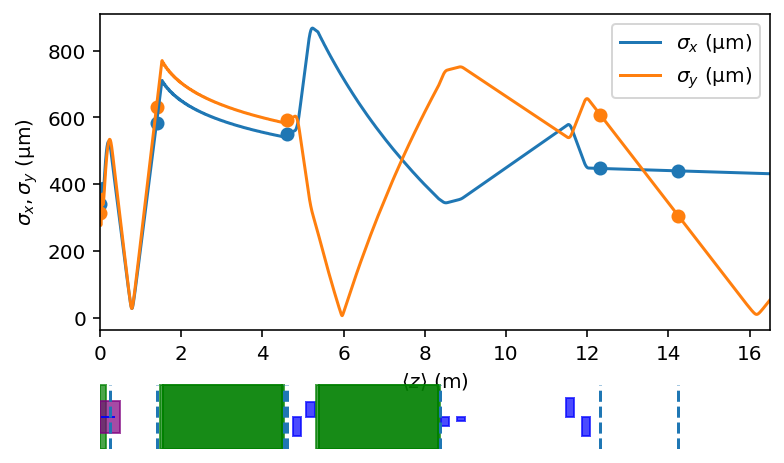

In [14]:
# Load into LUME-Impact
I = Impact.from_archive(afiles[0])
I.plot()

In [15]:
# Get some particles
P = I.particles['OTR2']
P

<ParticleGroup with 10000 particles at 0x1179faa00>

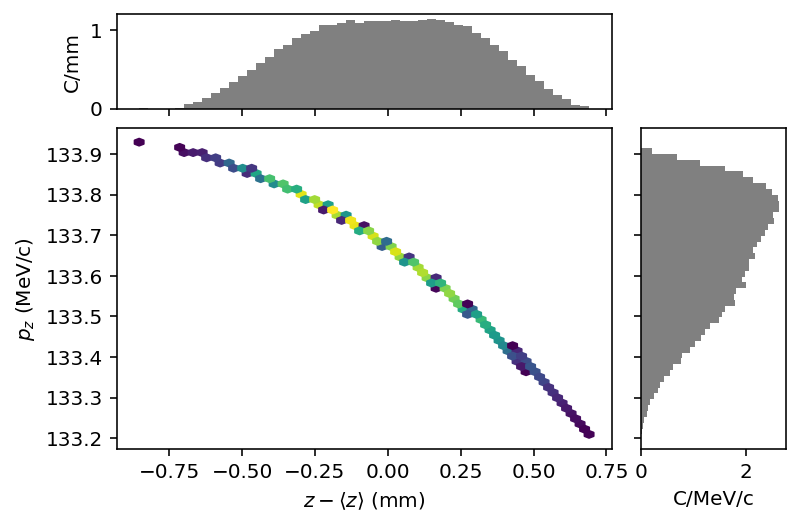

In [16]:
P.plot('delta_z', 'pz')

In [17]:
# Inspect the HDF5 archive
h5 = h5py.File(afiles[0])
dict(h5.attrs) # empty

{}

In [18]:
list(h5)

['distgen', 'impact']

In [19]:
dict(h5['distgen'].attrs)

{'dataType': b'distgen',
 'date': b'2022-03-21T19:18:14+00:00',
 'software': b'distgen',
 'version': b'0.6.1'}

In [20]:
dict(h5['impact'].attrs)

{'dataType': b'lume-impact',
 'date': b'2022-03-21T19:18:14+00:00',
 'software': b'lume-impact',
 'version': b'0.6.5'}